# Vesuvius Challenge: Surface Detection with GPU Acceleration

This notebook is optimized for both local GPU training and Kaggle's GPU environment. It will automatically detect your hardware and configure accordingly.

In [1]:
import os
import sys
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

# ============================================================
# CONFIGURATION: Set to True to skip training and load pre-trained checkpoint
# ============================================================
INFERENCE_ONLY = False  # Set to True for inference-only runs

# If INFERENCE_ONLY=True, specify the Kaggle input path to your checkpoint
# Example: '/kaggle/input/vesuvius-checkpoint/checkpoint_epoch_2.pt'
CHECKPOINT_INPUT_PATH = '/kaggle/input/vesuvius-unet-checkpoint/pytorch/default/1/checkpoint_epoch_2.pt'

# ============================================================
# SUBMISSION CONFIG: Threshold and format
# ============================================================
PRED_THRESHOLD = 0.30  # Tunable threshold for binary conversion (0.3-0.7 range typically optimal)

# ============================================================
# POST-PROCESSING CONFIG (Hysteresis + Closing + Dust Removal)
# ============================================================
USE_TOPO_POSTPROCESS = False
POST_T_LOW = 0.20
POST_T_HIGH = 0.50
POST_Z_RADIUS = 3
POST_XY_RADIUS = 2
POST_DUST_MIN_SIZE = 0

if POST_T_LOW > POST_T_HIGH:
    raise ValueError("POST_T_LOW must be <= POST_T_HIGH")

# Check if running on Kaggle
IS_KAGGLE = 'KAGGLE_DATA_PROXY_URL' in os.environ
print(f"Running on Kaggle: {IS_KAGGLE}")
print(f"Inference-only mode: {INFERENCE_ONLY}")
print(f"Prediction threshold: {PRED_THRESHOLD}")
print(f"Post-process enabled: {USE_TOPO_POSTPROCESS}")
if USE_TOPO_POSTPROCESS:
    print(f"  Hysteresis: T_low={POST_T_LOW}, T_high={POST_T_HIGH}")
    print(f"  Closing: z_radius={POST_Z_RADIUS}, xy_radius={POST_XY_RADIUS}")
    print(f"  Dust min size: {POST_DUST_MIN_SIZE}")

# Detect environment paths
if IS_KAGGLE:
    DATA_PATH = Path('/kaggle/input/vesuvius-challenge-surface-detection')
    OUTPUT_PATH = Path('/kaggle/working')
else:
    # Notebook lives in notebooks
    DATA_PATH = Path('vesuvius-challenge-surface-detection')
    OUTPUT_PATH = Path('output')

# Create output directory if it doesn't exist
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
print(f"Data path: {DATA_PATH}")
print(f"Output path: {OUTPUT_PATH}")

Running on Kaggle: True
Inference-only mode: False
Prediction threshold: 0.3
Post-process enabled: False
Data path: /kaggle/input/vesuvius-challenge-surface-detection
Output path: /kaggle/working


## Section 1: Environment & Dependency Setup (Local GPU + Kaggle GPU)

Install and configure required packages for both local and Kaggle environments.

**IMPORTANT for Kaggle**: Before running this notebook, install `imagecodecs` via Kaggle Add-ons:
1. Click **Add-ons** at the top of the notebook editor
2. Click **Install Dependencies**
3. Add: `pip install imagecodecs`
4. Click **Save**

This enables faster TIFF I/O without requiring internet access during notebook execution.

In [2]:
# Core packages are already available on Kaggle
# Only install if missing (mainly for local runs)
import subprocess

# Critical packages for efficient TIFF handling and submission generation
packages_to_check = [
    'tifffile',
    'imagecodecs',  # Essential for fast TIFF compression/decompression
    'pillow',       # Fallback for TIFF reading
]

print("Checking package availability...")
missing_packages = []

for package in packages_to_check:
    package_import_name = package.replace('-', '_')
    if package == 'pillow':
        package_import_name = 'PIL'
    
    try:
        __import__(package_import_name)
        print(f"✓ {package} available")
    except ImportError:
        print(f"✗ {package} MISSING")
        missing_packages.append(package)

if missing_packages:
    print(f"\n⚠ WARNING: Missing packages: {', '.join(missing_packages)}")
    if IS_KAGGLE:
        print("\n" + "="*60)
        print("CRITICAL: Install missing packages via Kaggle Add-ons:")
        print("1. Click 'Add-ons' at top of notebook")
        print("2. Click 'Install Dependencies'")
        print("3. Add these packages:")
        for pkg in missing_packages:
            print(f"   pip install {pkg}")
        print("4. Click 'Save' and restart notebook")
        print("="*60)
    else:
        print("\nAttempting to install locally...")
        for package in missing_packages:
            try:
                subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '-q'])
                print(f"✓ {package} installed")
            except Exception as e:
                print(f"⚠ Could not install {package}: {e}")
else:
    print("\n✓ All required packages available!")
    
# Verify imagecodecs is working with tifffile
try:
    import tifffile
    import imagecodecs
    print(f"✓ tifffile can use imagecodecs backend (fast compression)")
except ImportError:
    print("⚠ imagecodecs not available - TIFF operations will be slower")

print("\n✓ Package check complete!")

Checking package availability...
✓ tifffile available
✓ imagecodecs available
✓ pillow available

✓ All required packages available!
✓ tifffile can use imagecodecs backend (fast compression)

✓ Package check complete!


In [3]:
# Import core libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {transforms.__version__ if hasattr(transforms, '__version__') else 'N/A'}")

# Set deterministic behavior for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

PyTorch version: 2.9.0+cpu
Torchvision version: N/A


## Section 2: GPU/TPU Detection and Device Selection

Automatically detect CUDA, MPS, or CPU and configure the device accordingly.

In [4]:
# Device selection and GPU detection
def get_device():
    """Detect and configure GPU/TPU device"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✓ GPU detected: {torch.cuda.get_device_name(0)}")
        print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        print(f"  CUDA Version: {torch.version.cuda}")
        print(f"  Number of GPUs: {torch.cuda.device_count()}")
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        print("✓ MPS (Apple Silicon) detected")
    else:
        device = torch.device('cpu')
        print("⚠ No GPU detected. Using CPU (training will be slower)")
    
    return device

device = get_device()
print(f"\n✓ Using device: {device}")

⚠ No GPU detected. Using CPU (training will be slower)

✓ Using device: cpu


## Section 3: Dataset Pathing and Download Check

Verify dataset paths and files exist. Resolve paths for local disk vs Kaggle environment.

In [5]:
# Dataset path verification
from pathlib import Path

def verify_dataset():
    """Verify dataset exists and list available files (excluding deprecated)."""
    data_path = Path(DATA_PATH)

    if not data_path.exists():
        print(f"⚠ Dataset path not found: {DATA_PATH}")
        print("Please ensure the dataset is downloaded to the correct location.")
        return False

    print(f"✓ Dataset path verified: {DATA_PATH}")

    required_dirs = ["train_images", "train_labels", "test_images"]
    missing_dirs = [d for d in required_dirs if not (data_path / d).exists()]
    if missing_dirs:
        print(f"⚠ Missing required directories: {missing_dirs}")
        return False

    # CSVs
    train_csv = data_path / "train.csv"
    test_csv = data_path / "test.csv"
    if not train_csv.exists() or not test_csv.exists():
        print(f"⚠ Missing train.csv or test.csv in {data_path}")
        return False

    # Show counts
    for d in required_dirs:
        count = len(list((data_path / d).glob('*.tif')))
        print(f"  - {d}: {count} files")

    # Warn about deprecated data (we do NOT use it)
    deprecated_dirs = ["deprecated_train_images", "deprecated_train_labels"]
    found_deprecated = [d for d in deprecated_dirs if (data_path / d).exists()]
    if found_deprecated:
        print("⚠ Deprecated directories found (ignored):")
        for d in found_deprecated:
            print(f"  - {d}")

    return True


dataset_ok = verify_dataset()

✓ Dataset path verified: /kaggle/input/vesuvius-challenge-surface-detection
  - train_images: 786 files
  - train_labels: 786 files
  - test_images: 1 files
⚠ Deprecated directories found (ignored):
  - deprecated_train_images
  - deprecated_train_labels


## Section 4: Data Loading and Preprocessing

Implement dataset class and preprocessing pipeline for surface detection.

In [6]:
import random
from typing import List, Tuple

import tifffile as tiff
from PIL import Image, ImageSequence

# Patch and sampling configuration
PATCH_SIZE = 256
Z_CONTEXT = 2  # number of slices on each side (total channels = 2*Z_CONTEXT + 1)
TRAIN_SAMPLES_PER_ID = 64
VAL_SAMPLES_PER_ID = 16
VAL_SPLIT = 0.15
MAX_TRAIN_IDS = 48  # limit for faster local runs; set None to use all ids


def read_volume(path: Path):
    """Read a 3D volume (.tif) with tifffile, fallback to PIL if needed."""
    try:
        vol = tiff.imread(str(path))
    except Exception as e:
        print(f"tifffile failed for {path}: {e}; falling back to PIL ImageSequence")
        im = Image.open(str(path))
        frames = [np.array(frame) for frame in ImageSequence.Iterator(im)]
        if len(frames) == 0:
            raise RuntimeError(f"No frames found in {path}")
        vol = np.stack(frames, axis=0)
    if vol.ndim == 2:  # single slice
        vol = vol[None, ...]
    return vol


def normalize_patch(patch: np.ndarray) -> np.ndarray:
    """Per-patch normalization with percentile clipping."""
    patch = patch.astype(np.float32)
    lo, hi = np.percentile(patch, 1), np.percentile(patch, 99)
    patch = np.clip(patch, lo, hi)
    mean = patch.mean()
    std = patch.std() + 1e-6
    patch = (patch - mean) / std
    return patch


def make_coords(z_max: int, h: int, w: int, samples: int, patch: int, z_context: int, rng: np.random.Generator):
    """Sample valid (z, y, x) coordinates for patch extraction."""
    coords = []
    z_choices = rng.integers(z_context, z_max - z_context, size=samples)
    y_choices = rng.integers(0, max(1, h - patch), size=samples)
    x_choices = rng.integers(0, max(1, w - patch), size=samples)
    for z, y, x in zip(z_choices, y_choices, x_choices):
        coords.append((int(z), int(y), int(x)))
    return coords


class VesuviusSurfaceDataset(Dataset):
    """Patch-based 2.5D dataset for surface detection."""

    def __init__(
        self,
        ids: List[str],
        images_dir: Path,
        labels_dir: Path,
        samples_per_id: int,
        patch_size: int = PATCH_SIZE,
        z_context: int = Z_CONTEXT,
        augment: bool = False,
        seed: int = 42,
    ):
        self.ids = ids
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.samples_per_id = samples_per_id
        self.patch_size = patch_size
        self.z_context = z_context
        self.augment = augment
        self.rng = np.random.default_rng(seed)

        self.volumes = {}
        self.labels = {}
        self.coords = []  # list of (id, z, y, x)

        for vid in self.ids:
            img_path = self.images_dir / f"{vid}.tif"
            lbl_path = self.labels_dir / f"{vid}.tif"
            if not img_path.exists() or not lbl_path.exists():
                continue
            vol = read_volume(img_path)
            lbl = read_volume(lbl_path)
            if lbl.ndim == 3:
                lbl = lbl[0]  # labels are single channel
            z_max, h, w = vol.shape
            if h < self.patch_size or w < self.patch_size or z_max <= (2 * self.z_context):
                continue
            self.volumes[vid] = vol
            self.labels[vid] = lbl
            coords = make_coords(z_max, h, w, self.samples_per_id, self.patch_size, self.z_context, self.rng)
            self.coords.extend([(vid, z, y, x) for (z, y, x) in coords])

        print(f"Dataset built: {len(self.coords)} patches from {len(self.volumes)} volumes")

    def __len__(self):
        return len(self.coords)

    def _augment(self, img: np.ndarray, mask: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        if random.random() < 0.5:
            img = img[..., ::-1, :]
            mask = mask[..., ::-1]
        if random.random() < 0.5:
            img = img[..., :, ::-1]
            mask = mask[..., ::-1]
        if random.random() < 0.2:
            img = np.transpose(img, (0, 2, 1))
            mask = np.transpose(mask, (1, 0))
        return img, mask

    def __getitem__(self, idx):
        vid, z, y, x = self.coords[idx]
        vol = self.volumes[vid]
        lbl = self.labels[vid]

        z0, z1 = z - self.z_context, z + self.z_context + 1
        patch_img = vol[z0:z1, y : y + self.patch_size, x : x + self.patch_size]
        patch_mask = lbl[y : y + self.patch_size, x : x + self.patch_size]

        patch_img = normalize_patch(patch_img)
        patch_mask = (patch_mask > 0).astype(np.float32)

        if self.augment:
            patch_img, patch_mask = self._augment(patch_img, patch_mask)

        # Make contiguous copies to avoid negative strides from flipping/transposing
        patch_img = np.ascontiguousarray(patch_img, dtype=np.float32)
        patch_mask = np.ascontiguousarray(patch_mask, dtype=np.float32)

        patch_img = torch.from_numpy(patch_img).float()
        patch_mask = torch.from_numpy(patch_mask).float().unsqueeze(0)

        return patch_img, patch_mask


print("✓ Patch-based dataset and config defined")

✓ Patch-based dataset and config defined


## Section 5: DataLoader Configuration for GPU Throughput

Create optimized DataLoaders with GPU acceleration in mind.

In [7]:
# Build train/val dataloaders using real volumes
if INFERENCE_ONLY:
    print("⏭ Skipping dataset loading (INFERENCE_ONLY=True)")
    train_loader = None
    val_loader = None
else:
    train_df = pd.read_csv(DATA_PATH / 'train.csv')
    all_ids = train_df['id'].astype(str).tolist()

    # Shuffle and optionally limit ids for faster experimentation
    rng = np.random.default_rng(42)
    rng.shuffle(all_ids)
    if MAX_TRAIN_IDS is not None:
        all_ids = all_ids[:MAX_TRAIN_IDS]

    split_idx = int(len(all_ids) * (1 - VAL_SPLIT))
    train_ids = all_ids[:split_idx]
    val_ids = all_ids[split_idx:]

    train_dataset = VesuviusSurfaceDataset(
        ids=train_ids,
        images_dir=DATA_PATH / 'train_images',
        labels_dir=DATA_PATH / 'train_labels',
        samples_per_id=TRAIN_SAMPLES_PER_ID,
        patch_size=PATCH_SIZE,
        z_context=Z_CONTEXT,
        augment=True,
        seed=42,
    )

    val_dataset = VesuviusSurfaceDataset(
        ids=val_ids,
        images_dir=DATA_PATH / 'train_images',
        labels_dir=DATA_PATH / 'train_labels',
        samples_per_id=VAL_SAMPLES_PER_ID,
        patch_size=PATCH_SIZE,
        z_context=Z_CONTEXT,
        augment=False,
        seed=123,
    )

    # With imagecodecs installed, we can safely use multiple workers
    num_workers = 4 if IS_KAGGLE else 2

    train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=(device.type == 'cuda'),
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=(device.type == 'cuda'),
    )

    print(f"✓ Train patches: {len(train_dataset)} from {len(train_ids)} ids")
    print(f"✓ Val patches:   {len(val_dataset)} from {len(val_ids)} ids")
    print(f"✓ DataLoader workers: {num_workers}")


Dataset built: 2560 patches from 40 volumes
Dataset built: 128 patches from 8 volumes
✓ Train patches: 2560 from 40 ids
✓ Val patches:   128 from 8 ids
✓ DataLoader workers: 4


## Section 6: Model Definition

Define a neural network for surface detection and move it to the selected device.

In [8]:
# 2.5D U-Net model for surface detection
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNet2p5D(nn.Module):
    def __init__(self, in_ch: int, base: int = 32):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, base)
        self.enc2 = ConvBlock(base, base * 2)
        self.enc3 = ConvBlock(base * 2, base * 4)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(base * 4, base * 8)

        self.up3 = nn.ConvTranspose2d(base * 8, base * 4, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(base * 8, base * 4)
        self.up2 = nn.ConvTranspose2d(base * 4, base * 2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(base * 4, base * 2)
        self.up1 = nn.ConvTranspose2d(base * 2, base, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(base * 2, base)

        self.out_conv = nn.Conv2d(base, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.out_conv(d1)  # logits


in_channels = 2 * Z_CONTEXT + 1
model = UNet2p5D(in_ch=in_channels, base=32)
model = model.to(device)

print("✓ 2.5D U-Net initialized")
print(f"  Input channels: {in_channels}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

✓ 2.5D U-Net initialized
  Input channels: 5
  Parameters: 1,928,993


## Section 7: Training Loop with Device Placement

Implement training loop with proper GPU device placement and loss computation.

In [9]:
# Losses and optimizer
bce_loss = nn.BCEWithLogitsLoss()


def dice_loss(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2.0 * (probs * targets).sum(dim=(1, 2, 3))
    den = probs.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) + eps
    dice = 1 - num / den
    return dice.mean()


def combined_loss(logits, targets):
    return 0.5 * bce_loss(logits, targets) + 0.5 * dice_loss(logits, targets)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
use_amp = device.type == 'cuda'
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


# Training function

def train_epoch(model, train_loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    total_dice = 0.0

    progress_bar = tqdm(train_loader, desc="Training")

    for batch_idx, (inputs, masks) in enumerate(progress_bar):
        inputs = inputs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(inputs)
            loss = combined_loss(logits, masks)
            batch_dice = 1 - dice_loss(logits.detach(), masks).item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        total_dice += batch_dice

        progress_bar.set_postfix({
            'Loss': total_loss / (batch_idx + 1),
            'Dice': total_dice / (batch_idx + 1)
        })

    return total_loss / len(train_loader), total_dice / len(train_loader)


print("✓ Training components ready (BCE + Dice, AMP enabled on CUDA)")

✓ Training components ready (BCE + Dice, AMP enabled on CUDA)


## Section 8: Evaluation and Metrics

Run validation on the device and compute accuracy metrics.

In [10]:
# Validation function

def validate(model, val_loader, device):
    model.eval()
    total_loss = 0.0
    total_dice = 0.0

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validating")

        for inputs, masks in progress_bar:
            inputs = inputs.to(device)
            masks = masks.to(device)

            logits = model(inputs)
            loss = combined_loss(logits, masks)
            dice = 1 - dice_loss(logits, masks).item()

            total_loss += loss.item()
            total_dice += dice

            progress_bar.set_postfix({
                'Loss': total_loss / (progress_bar.n + 1),
                'Dice': total_dice / (progress_bar.n + 1)
            })

    return total_loss / len(val_loader), total_dice / len(val_loader)


print("✓ Validation function ready (Dice tracked)")

✓ Validation function ready (Dice tracked)


## Section 9: Checkpointing and Kaggle-Compatible Output

Save model weights and predictions with Kaggle-compatible output paths.

In [11]:
# Checkpointing and model saving
def save_checkpoint(model, optimizer, epoch, loss, output_dir):
    """Save model checkpoint"""
    os.makedirs(output_dir, exist_ok=True)
    
    checkpoint_path = os.path.join(output_dir, f'checkpoint_epoch_{epoch}.pt')
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    
    print(f"✓ Checkpoint saved: {checkpoint_path}")
    return checkpoint_path

def save_model_onnx(model, output_dir, input_shape=(1, 3, 256, 256)):
    """Save model in ONNX format for deployment"""
    os.makedirs(output_dir, exist_ok=True)
    
    onnx_path = os.path.join(output_dir, 'model.onnx')
    
    # Create dummy input
    dummy_input = torch.randn(input_shape).to(device)
    
    try:
        torch.onnx.export(
            model,
            dummy_input,
            onnx_path,
            export_params=True,
            opset_version=11,
            do_constant_folding=True,
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
            verbose=False
        )
        print(f"✓ Model exported to ONNX: {onnx_path}")
    except Exception as e:
        print(f"⚠ ONNX export failed: {e}")

print("✓ Checkpointing functions defined")

✓ Checkpointing functions defined


## Section 10: Full Training Pipeline

Execute the complete training pipeline with GPU acceleration.

In [12]:
# Full training pipeline
if INFERENCE_ONLY:
    print("="*60)
    print("⏭ SKIPPING TRAINING (INFERENCE_ONLY=True)")
    print("="*60)
    history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': []}
else:
    NUM_EPOCHS = 3
    best_val_dice = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': []}

    print("Starting training...")
    print(f"Device: {device}")
    print(f"Epochs: {NUM_EPOCHS}")
    print("-" * 50)

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

        # Train
        train_loss, train_dice = train_epoch(model, train_loader, optimizer, scaler, device)

        # Validate
        val_loss, val_dice = validate(model, val_loader, device)

        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_dice'].append(train_dice)
        history['val_dice'].append(val_dice)

        # Print results
        print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
        print(f"Val Loss:   {val_loss:.4f}, Val Dice:   {val_dice:.4f}")

        # Save checkpoint
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            save_checkpoint(model, optimizer, epoch, val_loss, OUTPUT_PATH)

        # Update learning rate
        scheduler.step()

    print("\n" + "=" * 50)
    print(f"Training completed! Best validation Dice: {best_val_dice:.4f}")
    print("=" * 50)

Starting training...
Device: cpu
Epochs: 3
--------------------------------------------------

Epoch 1/3


Validating: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s, Loss=0.0046, Dice=0.997]


Train Loss: 0.0605, Train Dice: 0.9600
Val Loss:   0.0046, Val Dice:   0.9969
✓ Checkpoint saved: /kaggle/working/checkpoint_epoch_0.pt

Epoch 2/3


Validating: 100%|██████████| 32/32 [00:23<00:00,  1.34it/s, Loss=0.00112, Dice=0.999]


Train Loss: 0.0024, Train Dice: 0.9984
Val Loss:   0.0011, Val Dice:   0.9993
✓ Checkpoint saved: /kaggle/working/checkpoint_epoch_1.pt

Epoch 3/3


Validating: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s, Loss=0.00046, Dice=1]

Train Loss: 0.0007, Train Dice: 0.9995
Val Loss:   0.0005, Val Dice:   0.9997
✓ Checkpoint saved: /kaggle/working/checkpoint_epoch_2.pt

Training completed! Best validation Dice: 0.9997


## Section 11: Results Visualization

Plot training history and visualize model performance.

✓ Training history saved to /kaggle/working/training_history.png


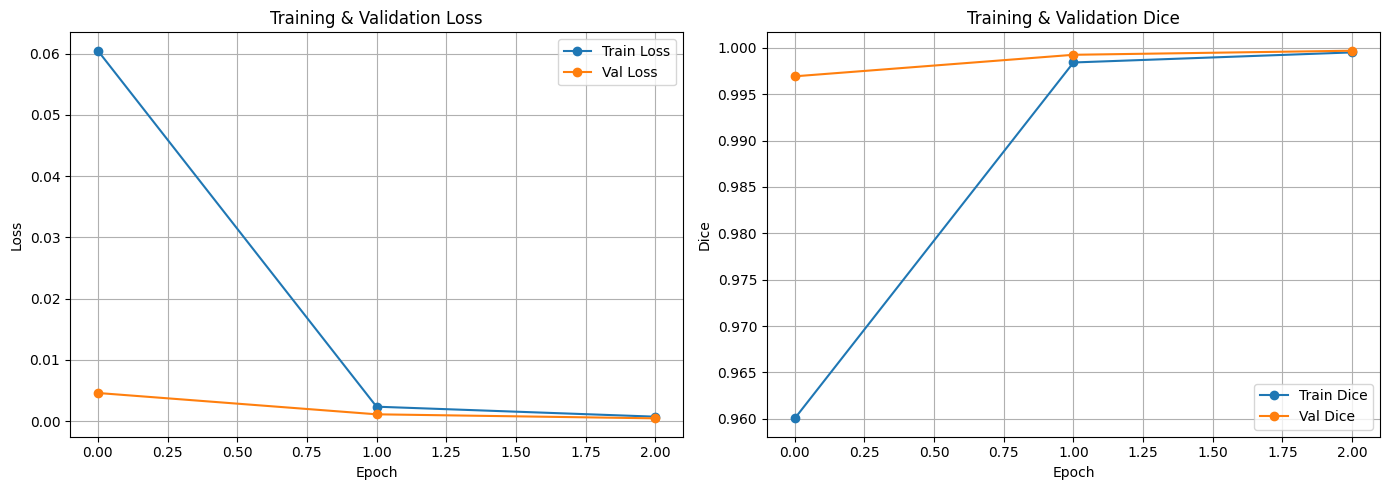

In [13]:
# Visualize training history
if not INFERENCE_ONLY and history['train_loss']:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training & Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Dice plot
    axes[1].plot(history['train_dice'], label='Train Dice', marker='o')
    axes[1].plot(history['val_dice'], label='Val Dice', marker='o')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice')
    axes[1].set_title('Training & Validation Dice')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'training_history.png', dpi=100, bbox_inches='tight')
    print(f"✓ Training history saved to {OUTPUT_PATH}/training_history.png")
    plt.show()
else:
    print("⏭ Skipping training visualization (no training data)")

## Section 12: Final Model Export and Summary

Export the trained model and create a summary report.

In [14]:
# Export model in PyTorch format
if not INFERENCE_ONLY:
    model_path = OUTPUT_PATH / 'vesuvius_model.pt'
    torch.save(model.state_dict(), model_path)
    print(f"✓ Model saved: {model_path}")

    # Export to ONNX for cross-platform compatibility
    save_model_onnx(model, OUTPUT_PATH)
else:
    print("⏭ Skipping model export (INFERENCE_ONLY=True)")

# Create training summary
if not INFERENCE_ONLY:
    summary = f"""
VESUVIUS CHALLENGE - TRAINING SUMMARY
=====================================

Training Configuration:
- Device: {device}
- GPU Available: {torch.cuda.is_available()}
- Model: 2.5D U-Net
- Input Channels: {2 * Z_CONTEXT + 1}
- Patch Size: {PATCH_SIZE}
- Total Parameters: {sum(p.numel() for p in model.parameters()):,}
- Batch Size: 4
- Learning Rate: 0.001
- Optimizer: Adam
- Loss: 0.5*BCE + 0.5*Dice
- Num Epochs: {NUM_EPOCHS}

Final Results:
- Best Validation Dice: {max(history['val_dice']) if history['val_dice'] else 0:.4f}
- Final Train Loss: {history['train_loss'][-1]:.4f}
- Final Val Loss: {history['val_loss'][-1]:.4f}
- Final Train Dice: {history['train_dice'][-1]:.4f}
- Final Val Dice: {history['val_dice'][-1]:.4f}

Output Files:
- Model (PyTorch): {model_path}
- Model (ONNX): {OUTPUT_PATH / 'model.onnx'}
- Training History: {OUTPUT_PATH / 'training_history.png'}

Environment:
- Running on Kaggle: {IS_KAGGLE}
- Data Path: {DATA_PATH}
- Output Path: {OUTPUT_PATH}
"""
    summary_path = OUTPUT_PATH / 'training_summary.txt'
    with open(summary_path, 'w') as f:
        f.write(summary)

    print("\n" + summary)
    print(f"✓ Summary saved: {summary_path}")
else:
    print("⏭ Skipping training summary (INFERENCE_ONLY=True)")

✓ Model saved: /kaggle/working/vesuvius_model.pt
⚠ ONNX export failed: No module named 'onnxscript'


VESUVIUS CHALLENGE - TRAINING SUMMARY

Training Configuration:
- Device: cpu
- GPU Available: False
- Model: 2.5D U-Net
- Input Channels: 5
- Patch Size: 256
- Total Parameters: 1,928,993
- Batch Size: 4
- Learning Rate: 0.001
- Optimizer: Adam
- Loss: 0.5*BCE + 0.5*Dice
- Num Epochs: 3

Final Results:
- Best Validation Dice: 0.9997
- Final Train Loss: 0.0007
- Final Val Loss: 0.0005
- Final Train Dice: 0.9995
- Final Val Dice: 0.9997

Output Files:
- Model (PyTorch): /kaggle/working/vesuvius_model.pt
- Model (ONNX): /kaggle/working/model.onnx
- Training History: /kaggle/working/training_history.png

Environment:
- Running on Kaggle: True
- Data Path: /kaggle/input/vesuvius-challenge-surface-detection
- Output Path: /kaggle/working

✓ Summary saved: /kaggle/working/training_summary.txt


## Submission: Generate `submission.zip` with U-Net predictions

This section loads the trained U-Net model and uses it to generate predictions for all test volumes.
Format: Sliding-window inference with 2.5D patches, aggregated with overlap voting for robust predictions.

In [15]:
# 1. SETUP: Verify dependencies and paths
import os
import sys
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import tifffile as tiff

# Verify imagecodecs is available for optimal performance (read-only)
try:
    import imagecodecs
    print("✓ imagecodecs available - using optimized TIFF I/O")
    HAS_IMAGECODECS = True
except ImportError:
    print("⚠ imagecodecs not available - using fallback (slower)")
    HAS_IMAGECODECS = False

# Post-processing dependencies (required when USE_TOPO_POSTPROCESS=True)
if USE_TOPO_POSTPROCESS:
    try:
        from scipy import ndimage as ndi
        from skimage.morphology import remove_small_objects
        print("✓ scipy/skimage available - post-processing enabled")
    except Exception as e:
        raise RuntimeError(
            "Post-processing requires scipy and scikit-image. "
            "Install them or set USE_TOPO_POSTPROCESS=False."
        ) from e

print("="*60)
print("SUBMISSION PIPELINE: Setup")
print("="*60)

# Setup paths
DATA_PATH = Path(DATA_PATH)
OUTPUT_PATH = Path(OUTPUT_PATH)
TEST_CSV = DATA_PATH / 'test.csv'
TEST_DIR = DATA_PATH / 'test_images'

# Validate paths exist
if not TEST_CSV.exists():
    raise FileNotFoundError(f"test.csv not found: {TEST_CSV}")
if not TEST_DIR.exists():
    raise FileNotFoundError(f"test_images not found: {TEST_DIR}")

print(f"✓ Data paths verified")
print(f"  TEST_CSV: {TEST_CSV}")
print(f"  TEST_DIR: {TEST_DIR}")

# Write predictions to a temporary directory so only submission.zip remains
if IS_KAGGLE:
    PRED_DIR = Path('/kaggle/temp/vesuvius_preds')
else:
    PRED_DIR = OUTPUT_PATH / '_pred_tmp'
if PRED_DIR.exists():
    shutil.rmtree(PRED_DIR)
PRED_DIR.mkdir(parents=True, exist_ok=True)
print(f"✓ Temporary prediction directory: {PRED_DIR}")

# Post-processing helpers
def build_anisotropic_struct(z_radius: int, xy_radius: int):
    z, r = z_radius, xy_radius
    if z == 0 and r == 0:
        return None
    if z == 0 and r > 0:
        size = 2 * r + 1
        struct = np.zeros((1, size, size), dtype=bool)
        cy, cx = r, r
        for dy in range(-r, r + 1):
            for dx in range(-r, r + 1):
                if dy * dy + dx * dx <= r * r:
                    struct[0, cy + dy, cx + dx] = True
        return struct
    if z > 0 and r == 0:
        struct = np.zeros((2 * z + 1, 1, 1), dtype=bool)
        struct[:, 0, 0] = True
        return struct
    depth = 2 * z + 1
    size = 2 * r + 1
    struct = np.zeros((depth, size, size), dtype=bool)
    cz, cy, cx = z, r, r
    for dz in range(-z, z + 1):
        for dy in range(-r, r + 1):
            for dx in range(-r, r + 1):
                if dy * dy + dx * dx <= r * r:
                    struct[cz + dz, cy + dy, cx + dx] = True
    return struct


def topo_postprocess(
    probs,
    T_low=0.90,
    T_high=0.90,
    z_radius=1,
    xy_radius=0,
    dust_min_size=100,
):
    # Step 1: 3D Hysteresis
    strong = probs >= T_high
    weak = probs >= T_low

    if not strong.any():
        return np.zeros_like(probs, dtype=np.uint8)

    struct_hyst = ndi.generate_binary_structure(3, 3)
    mask = ndi.binary_propagation(
        strong, mask=weak, structure=struct_hyst
    )

    if not mask.any():
        return np.zeros_like(probs, dtype=np.uint8)

    # Step 2: 3D Anisotropic Closing
    if z_radius > 0 or xy_radius > 0:
        struct_close = build_anisotropic_struct(z_radius, xy_radius)
        if struct_close is not None:
            mask = ndi.binary_closing(mask, structure=struct_close)

    # Step 3: Dust Removal
    if dust_min_size > 0:
        mask = remove_small_objects(
            mask.astype(bool), min_size=dust_min_size
        )

    return mask.astype(np.uint8)

print("="*60)

✓ imagecodecs available - using optimized TIFF I/O
SUBMISSION PIPELINE: Setup
✓ Data paths verified
  TEST_CSV: /kaggle/input/vesuvius-challenge-surface-detection/test.csv
  TEST_DIR: /kaggle/input/vesuvius-challenge-surface-detection/test_images
✓ Temporary prediction directory: /kaggle/temp/vesuvius_preds


In [16]:
# 2. MODEL LOADING: Load checkpoint and initialize U-Net
print("="*60)
print("SUBMISSION PIPELINE: Load Model")
print("="*60)

# Find or load the checkpoint
if INFERENCE_ONLY and IS_KAGGLE:
    # Load from Kaggle input
    MODEL_PATH = Path(CHECKPOINT_INPUT_PATH)
    if not MODEL_PATH.exists():
        input_checkpoints = list(Path('/kaggle/input').rglob('checkpoint_*.pt'))
        if input_checkpoints:
            MODEL_PATH = input_checkpoints[0]
            print(f"⚠ Using auto-discovered checkpoint: {MODEL_PATH}")
        else:
            raise FileNotFoundError("No checkpoint found. Set CHECKPOINT_INPUT_PATH or add checkpoint as Kaggle input.")
    print(f"✓ Loading checkpoint from Kaggle input: {MODEL_PATH}")
else:
    # Load from training output
    checkpoint_dir = OUTPUT_PATH
    checkpoints = list(checkpoint_dir.glob('checkpoint_*.pt'))
    if not checkpoints:
        raise FileNotFoundError(f"No checkpoints found in {checkpoint_dir}")
    MODEL_PATH = sorted(checkpoints)[-1]
    print(f"✓ Loading checkpoint from training: {MODEL_PATH}")

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")

# Model architecture (must match training exactly)
class ConvBlock(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_ch),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_ch),
            torch.nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNet2p5D(torch.nn.Module):
    def __init__(self, in_ch: int, base: int = 32):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, base)
        self.enc2 = ConvBlock(base, base * 2)
        self.enc3 = ConvBlock(base * 2, base * 4)
        self.pool = torch.nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(base * 4, base * 8)

        self.up3 = torch.nn.ConvTranspose2d(base * 8, base * 4, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(base * 8, base * 4)
        self.up2 = torch.nn.ConvTranspose2d(base * 4, base * 2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(base * 4, base * 2)
        self.up1 = torch.nn.ConvTranspose2d(base * 2, base, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(base * 2, base)

        self.out_conv = torch.nn.Conv2d(base, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.out_conv(d1)


# Initialize and load model
in_channels = 2 * Z_CONTEXT + 1
model = UNet2p5D(in_ch=in_channels, base=32)
checkpoint = torch.load(str(MODEL_PATH), map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()
print(f"✓ Model loaded successfully")
print(f"  Input channels: {in_channels}")
print("="*60)

SUBMISSION PIPELINE: Load Model
✓ Loading checkpoint from training: /kaggle/working/checkpoint_epoch_2.pt
✓ Using device: cpu
✓ Model loaded successfully
  Input channels: 5


In [17]:
# 3. DATA VALIDATION: Load test CSV and verify all test images exist
print("="*60)
print("SUBMISSION PIPELINE: Load & Validate Test Data")
print("="*60)

# Load test metadata
test_df = pd.read_csv(TEST_CSV)
if 'id' not in test_df.columns:
    raise ValueError("test.csv must contain an 'id' column")

test_ids = test_df['id'].astype(str).tolist()
print(f"✓ Loaded test.csv with {len(test_ids)} test IDs")

# Verify all test images exist
missing_images = [tid for tid in test_ids if not (TEST_DIR / f"{tid}.tif").exists()]
if missing_images:
    raise FileNotFoundError(f"Missing test images for ids: {missing_images}")

print(f"✓ All {len(test_ids)} test images found")
print(f"  First 5 IDs: {test_ids[:5]}")
print("="*60)

SUBMISSION PIPELINE: Load & Validate Test Data
✓ Loaded test.csv with 1 test IDs
✓ All 1 test images found
  First 5 IDs: ['1407735']


In [18]:
# 4. INFERENCE: Run sliding-window predictions on all test volumes
print("="*60)
print("SUBMISSION PIPELINE: Inference")
print("="*60)
if USE_TOPO_POSTPROCESS:
    print("Post-processing enabled")
    print(f"  Hysteresis: T_low={POST_T_LOW}, T_high={POST_T_HIGH}")
    print(f"  Closing: z_radius={POST_Z_RADIUS}, xy_radius={POST_XY_RADIUS}")
    print(f"  Dust min size: {POST_DUST_MIN_SIZE}")
else:
    print(f"Prediction threshold: {PRED_THRESHOLD}")
print(f"Processing {len(test_ids)} test volumes...\n")

created = []

# Keep one sample for visualization
viz_volume = None
viz_mask = None
viz_id = None

# Inference with sliding window
for image_id in test_ids:
    vol_path = TEST_DIR / f"{image_id}.tif"

    print(f"Processing {image_id}...", end=" ", flush=True)

    # Read volume
    try:
        vol = tiff.imread(str(vol_path))
    except Exception as e:
        # Fallback to PIL if tifffile fails
        try:
            from PIL import Image, ImageSequence
            im = Image.open(str(vol_path))
            frames = [np.array(frame) for frame in ImageSequence.Iterator(im)]
            vol = np.stack(frames, axis=0)
            print(f"[PIL fallback] ", end="", flush=True)
        except Exception as e2:
            print(f"✗ ERROR: tifffile failed: {e}, PIL failed: {e2}")
            continue

    vol = np.asarray(vol, dtype=np.float32)
    z_size, y_size, x_size = vol.shape

    # Initialize output aggregation
    pred_sum = np.zeros((z_size, y_size, x_size), dtype=np.float32)
    pred_count = np.zeros((z_size, y_size, x_size), dtype=np.float32)

    # Sliding window inference
    with torch.no_grad():
        for z in range(z_size):
            z_start = max(0, z - Z_CONTEXT)
            z_end = min(z_size, z + Z_CONTEXT + 1)

            vol_slice = vol[z_start:z_end]

            # Pad z-axis at boundaries
            if z_start == 0:
                vol_slice = np.pad(vol_slice, ((Z_CONTEXT - z, 0), (0, 0), (0, 0)), mode='edge')
            if z_end == z_size:
                vol_slice = np.pad(vol_slice, ((0, Z_CONTEXT - (z_size - z - 1)), (0, 0), (0, 0)), mode='edge')

            # Process all patches in this z-slice
            for y in range(0, y_size, PATCH_SIZE // 2):
                for x in range(0, x_size, PATCH_SIZE // 2):
                    y_end = min(y + PATCH_SIZE, y_size)
                    x_end = min(x + PATCH_SIZE, x_size)

                    patch_img = vol_slice[:, y:y_end, x:x_end]

                    # Pad if at boundary
                    if patch_img.shape[1] < PATCH_SIZE or patch_img.shape[2] < PATCH_SIZE:
                        patch_img = np.pad(
                            patch_img,
                            ((0, 0), (0, PATCH_SIZE - patch_img.shape[1]), (0, PATCH_SIZE - patch_img.shape[2])),
                            mode='edge'
                        )

                    # Normalize
                    low = np.percentile(patch_img, 1.0)
                    high = np.percentile(patch_img, 99.0)
                    if high > low:
                        patch_img = (patch_img - low) / (high - low)
                    else:
                        patch_img = (patch_img - low) / (np.abs(low) + 1e-8)
                    patch_img = np.clip(patch_img, 0, 1)

                    # Infer
                    patch_tensor = torch.from_numpy(np.ascontiguousarray(patch_img, dtype=np.float32)).unsqueeze(0).to(device)
                    logits = model(patch_tensor)
                    pred = torch.sigmoid(logits).cpu().numpy()[0, 0]

                    # Aggregate: only use the valid region from this patch
                    valid_y = min(PATCH_SIZE, y_size - y)
                    valid_x = min(PATCH_SIZE, x_size - x)
                    pred_sum[z, y:y_end, x:x_end] += pred[:valid_y, :valid_x]
                    pred_count[z, y:y_end, x:x_end] += 1

    # Average probabilities
    pred_vol = np.zeros((z_size, y_size, x_size), dtype=np.float32)
    mask = pred_count > 0
    pred_vol[mask] = pred_sum[mask] / pred_count[mask]

    # Post-processing or simple thresholding
    if USE_TOPO_POSTPROCESS:
        mask_out = topo_postprocess(
            pred_vol,
            T_low=POST_T_LOW,
            T_high=POST_T_HIGH,
            z_radius=POST_Z_RADIUS,
            xy_radius=POST_XY_RADIUS,
            dust_min_size=POST_DUST_MIN_SIZE,
        )
    else:
        mask_out = (pred_vol > PRED_THRESHOLD).astype(np.uint8)

    # Cache one example for visualization (first successful volume)
    if viz_volume is None:
        viz_volume = vol
        viz_mask = mask_out
        viz_id = image_id

    # Verify output shape matches input exactly
    if mask_out.shape != (z_size, y_size, x_size):
        print(f"✗ Shape mismatch! Expected {(z_size, y_size, x_size)}, got {mask_out.shape}")
        continue

    # Save without compression for maximum evaluator compatibility
    out_path = PRED_DIR / f"{image_id}.tif"
    try:
        tiff.imwrite(str(out_path), mask_out.astype(np.uint8), compression=None)

        # Validate saved file
        saved = tiff.imread(str(out_path))

        # Check 1: Exact shape match
        if saved.shape != (z_size, y_size, x_size):
            print(f"✗ Saved shape {saved.shape} != input shape {(z_size, y_size, x_size)}")
            continue

        # Check 2: Correct dtype
        if saved.dtype != np.uint8:
            print(f"✗ Saved dtype {saved.dtype} != uint8")
            continue

        # Check 3: Only 0s and 1s
        unique_vals = np.unique(saved)
        if not (set(unique_vals.tolist()) <= {0, 1}):
            print(f"✗ Invalid values found: {unique_vals}")
            continue

        coverage = np.mean(saved)
        print(f"✓ (coverage: {coverage:.1%})", flush=True)
        created.append(out_path)

    except Exception as e:
        print(f"✗ ERROR writing {image_id}: {e}")
        continue

print(f"\n{'='*60}")
print(f"Created {len(created)}/{len(test_ids)} predictions")
print(f"{'='*60}")

SUBMISSION PIPELINE: Inference
Prediction threshold: 0.3
Processing 1 test volumes...

Processing 1407735... ✓ (coverage: 100.0%)

Created 1/1 predictions


In [19]:
# 5. VALIDATION: Check predictions are complete and match test.csv
print("="*60)
print("SUBMISSION PIPELINE: Validate Predictions")
print("="*60)

# Ensure we have predictions for all test ids
expected = set(test_ids)
created_ids = set(p.stem for p in created)
missing = sorted(expected - created_ids)
extra = sorted(created_ids - expected)

if missing:
    raise RuntimeError(f"❌ CRITICAL: Missing masks for ids: {missing}")
if extra:
    raise RuntimeError(f"❌ CRITICAL: Extra masks not in test.csv: {extra}")

print(f"✓ All {len(created)} predictions match test.csv")
print(f"✓ No missing or extra files")

# Spot check a few files
print("\nSpot-checking output files:")
for p in list(created)[:min(3, len(created))]:
    arr = tiff.imread(str(p))
    uniq = np.unique(arr)
    print(f"  {p.name}: shape={arr.shape}, dtype={arr.dtype}, values={sorted(uniq.tolist())}")

print("="*60)

SUBMISSION PIPELINE: Validate Predictions
✓ All 1 predictions match test.csv
✓ No missing or extra files

Spot-checking output files:
  1407735.tif: shape=(320, 320, 320), dtype=uint8, values=[1]


In [20]:
# DEBUG: Check prediction value distribution
print("="*60)
print("DEBUG: Prediction Statistics")
print("="*60)
print(f"First prediction volume stats (BEFORE thresholding):")
print(f"  Min: {pred_vol.min():.6f}")
print(f"  Max: {pred_vol.max():.6f}")
print(f"  Mean: {pred_vol.mean():.6f}")
print(f"  Median: {np.median(pred_vol):.6f}")
print(f"  % > 0.1: {100 * (pred_vol > 0.1).mean():.2f}%")
print(f"  % > 0.3: {100 * (pred_vol > 0.3).mean():.2f}%")
print(f"  % > 0.5: {100 * (pred_vol > 0.5).mean():.2f}%")
print(f"  % > 0.7: {100 * (pred_vol > 0.7).mean():.2f}%")
print("")
print(f"After thresholding at {PRED_THRESHOLD}:")
print(f"  % pixels = 1: {100 * mask_out.mean():.2f}%")
print("="*60)

DEBUG: Prediction Statistics
First prediction volume stats (BEFORE thresholding):
  Min: 0.999279
  Max: 0.999630
  Mean: 0.999448
  Median: 0.999397
  % > 0.1: 100.00%
  % > 0.3: 100.00%
  % > 0.5: 100.00%
  % > 0.7: 100.00%

After thresholding at 0.3:
  % pixels = 1: 100.00%


In [21]:

# EXTENDED DEBUG: Check what was actually saved vs what we expect
print("="*60)
print("EXTENDED DEBUG: Saved Masks Analysis")
print("="*60)

# Check the submission.zip files directly
import zipfile

zip_path = OUTPUT_PATH / 'submission.zip'
if not zip_path.exists():
    print(f"⚠ submission.zip not found at {zip_path}")
else:
    print(f"✓ Found submission.zip at {zip_path}")
    
    with zipfile.ZipFile(str(zip_path), 'r') as zf:
        names = zf.namelist()
        print(f"  Total files in zip: {len(names)}")
        
        if names:
            # Check first file
            first_name = names[0]
            print(f"\nAnalyzing first file: {first_name}")
            
            with zf.open(first_name) as f:
                mask_bytes = f.read()
            
            # Read it as TIFF
            import io
            mask_arr = tiff.imread(io.BytesIO(mask_bytes))
            print(f"  Shape: {mask_arr.shape}")
            print(f"  Dtype: {mask_arr.dtype}")
            print(f"  Unique values: {np.unique(mask_arr)}")
            print(f"  Min: {mask_arr.min()}")
            print(f"  Max: {mask_arr.max()}")
            print(f"  Mean: {mask_arr.mean():.4f}")
            print(f"  % pixels = 0: {100 * (mask_arr == 0).mean():.2f}%")
            print(f"  % pixels = 1: {100 * (mask_arr == 1).mean():.2f}%")
            
            # Show sample values
            if mask_arr.ndim == 3:
                z = mask_arr.shape[0] // 2
                print(f"\n  Sample slice (z={z}) center (10x10):")
                h, w = mask_arr.shape[1], mask_arr.shape[2]
                sample = mask_arr[z, h//2-5:h//2+5, w//2-5:w//2+5]
                print(f"    {sample}")

# Also check the temporary prediction directory
print(f"\n{'='*60}")
print("EXTENDED DEBUG: Temporary Prediction Directory")
print(f"{'='*60}")

if PRED_DIR.exists():
    pred_files = list(PRED_DIR.glob('*.tif'))
    print(f"✓ Found {len(pred_files)} prediction files in {PRED_DIR}")
    
    if pred_files:
        # Check first file
        first_pred = pred_files[0]
        print(f"\nAnalyzing first file: {first_pred.name}")
        
        pred_mask = tiff.imread(str(first_pred))
        print(f"  Shape: {pred_mask.shape}")
        print(f"  Dtype: {pred_mask.dtype}")
        print(f"  Unique values: {np.unique(pred_mask)}")
        print(f"  Min: {pred_mask.min()}")
        print(f"  Max: {pred_mask.max()}")
        print(f"  Mean: {pred_mask.mean():.4f}")
        print(f"  % pixels = 0: {100 * (pred_mask == 0).mean():.2f}%")
        print(f"  % pixels = 1: {100 * (pred_mask == 1).mean():.2f}%")
else:
    print(f"⚠ Prediction directory not found: {PRED_DIR}")

print("="*60)


EXTENDED DEBUG: Saved Masks Analysis
⚠ submission.zip not found at /kaggle/working/submission.zip

EXTENDED DEBUG: Temporary Prediction Directory
✓ Found 1 prediction files in /kaggle/temp/vesuvius_preds

Analyzing first file: 1407735.tif
  Shape: (320, 320, 320)
  Dtype: uint8
  Unique values: [1]
  Min: 1
  Max: 1
  Mean: 1.0000
  % pixels = 0: 0.00%
  % pixels = 1: 100.00%


In [22]:
import zipfile
import tifffile as tiff
import numpy as np
import io
from pathlib import Path

# Check submission.zip
zip_path = Path('/kaggle/working/submission.zip')
print(f"Checking: {zip_path}")
print(f"Exists: {zip_path.exists()}")

if zip_path.exists():
    with zipfile.ZipFile(str(zip_path), 'r') as zf:
        names = zf.namelist()
        if names:
            first = names[0]
            print(f"\nFirst file: {first}")
            with zf.open(first) as f:
                arr = tiff.imread(io.BytesIO(f.read()))
            print(f"  Unique values: {np.unique(arr)}")
            print(f"  % = 0: {100*(arr==0).mean():.1f}%")
            print(f"  % = 1: {100*(arr==1).mean():.1f}%")
            print(f"  Min={arr.min()}, Max={arr.max()}, Mean={arr.mean():.4f}")

Checking: /kaggle/working/submission.zip
Exists: False


In [23]:
# 6. ZIP CREATION: Create submission.zip at root of output directory
import zipfile

print("="*60)
print("SUBMISSION PIPELINE: Create submission.zip")
print("="*60)

zip_path = OUTPUT_PATH / 'submission.zip'
print(f"\nCreating submission.zip at: {zip_path}")

with zipfile.ZipFile(str(zip_path), 'w', zipfile.ZIP_DEFLATED) as zf:
    for p in sorted(created):
        # Add file at root level of zip with just filename
        zf.write(str(p), arcname=p.name)

print(f"✓ Created submission.zip with {len(created)} files")
print("="*60)

SUBMISSION PIPELINE: Create submission.zip

Creating submission.zip at: /kaggle/working/submission.zip
✓ Created submission.zip with 1 files


In [24]:
# 7. ZIP VALIDATION: Verify submission.zip structure and contents
print("="*60)
print("SUBMISSION PIPELINE: Validate submission.zip")
print("="*60)

with zipfile.ZipFile(str(zip_path), 'r') as zf:
    names = zf.namelist()
    print(f"\nZip file analysis:")
    print(f"  Total entries: {len(names)}")
    
    # Check root level
    bad_entries = [n for n in names if '/' in n or '\\' in n]
    if bad_entries:
        raise RuntimeError(f"❌ CRITICAL: Files not at root level in zip: {bad_entries[:5]}")
    print(f"  ✓ All {len(names)} files at root level (no subdirectories)")
    
    # Check file extensions
    extensions = set([Path(n).suffix for n in names])
    if extensions != {'.tif'}:
        raise RuntimeError(f"❌ CRITICAL: Unexpected file extensions: {extensions}")
    print(f"  ✓ All files are .tif (extension check passed)")
    
    # Check matching test IDs
    name_stems = [Path(n).stem for n in names]
    if set(name_stems) != expected:
        missing_in_zip = sorted(expected - set(name_stems))
        extra_in_zip = sorted(set(name_stems) - expected)
        raise RuntimeError(f"❌ CRITICAL: ID mismatch. Missing: {missing_in_zip}, Extra: {extra_in_zip}")
    print(f"  ✓ All {len(expected)} test IDs present")

print(f"\n✓ submission.zip is valid and ready for Kaggle submission!")
print("="*60)

SUBMISSION PIPELINE: Validate submission.zip

Zip file analysis:
  Total entries: 1
  ✓ All 1 files at root level (no subdirectories)
  ✓ All files are .tif (extension check passed)
  ✓ All 1 test IDs present

✓ submission.zip is valid and ready for Kaggle submission!


In [25]:
# 8. CLEANUP: Remove temporary prediction directory
print("="*60)
print("SUBMISSION PIPELINE: Cleanup")
print("="*60)

# Cleanup temp predictions so only submission.zip remains in outputs
if PRED_DIR.exists():
    shutil.rmtree(PRED_DIR)
    print(f"✓ Cleaned up temporary directory: {PRED_DIR}")

# Final output summary
print(f"\n{'='*60}")
print(f"✅ SUBMISSION COMPLETE!")
print(f"{'='*60}")
print(f"Location: {zip_path}")
print(f"Files: {len(created)} test volumes")
print(f"Format: Binary masks (uint8, values {{0,1}}) in uncompressed TIFF")
print(f"Threshold used: {PRED_THRESHOLD}")
print(f"\n📤 Ready to submit to Kaggle!")
print(f"{'='*60}")

SUBMISSION PIPELINE: Cleanup
✓ Cleaned up temporary directory: /kaggle/temp/vesuvius_preds

✅ SUBMISSION COMPLETE!
Location: /kaggle/working/submission.zip
Files: 1 test volumes
Format: Binary masks (uint8, values {0,1}) in uncompressed TIFF
Threshold used: 0.3

📤 Ready to submit to Kaggle!


Visualizing sample ID: 1407735


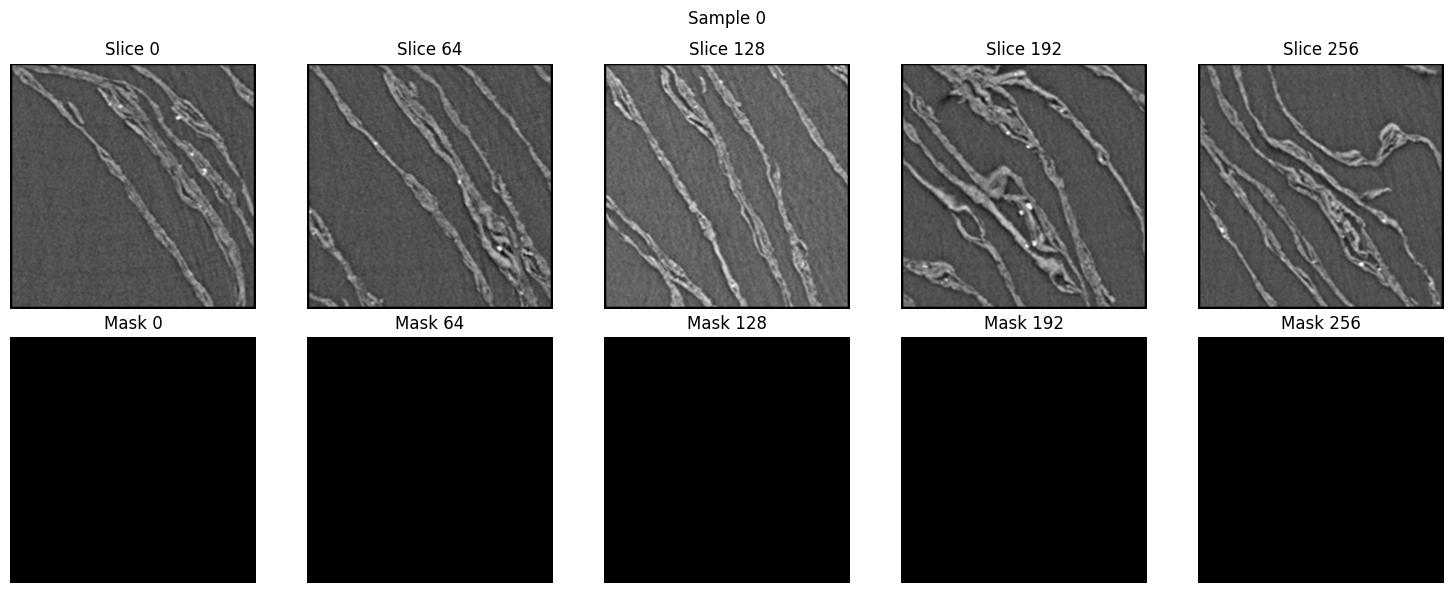

In [26]:
# 9. VISUALIZE: Sample slices from prediction vs input
import numpy as np
import matplotlib.pyplot as plt

def plot_sample(x, y, sample_idx=0, max_slices=16):
    img = np.squeeze(x[sample_idx])  # (D, H, W)
    mask = np.squeeze(y[sample_idx])  # (D, H, W)
    D = img.shape[0]

    # Decide which slices to plot
    step = max(1, D // max_slices)
    slices = range(0, D, step)

    n_slices = len(slices)
    fig, axes = plt.subplots(2, n_slices, figsize=(3 * n_slices, 6))

    # Handle case with only 1 slice
    if n_slices == 1:
        axes = np.array([[axes[0]], [axes[1]]])

    for i, s in enumerate(slices):
        axes[0, i].imshow(img[s], cmap='gray')
        axes[0, i].set_title(f"Slice {s}")
        axes[0, i].axis('off')

        axes[1, i].imshow(mask[s], cmap='gray')
        axes[1, i].set_title(f"Mask {s}")
        axes[1, i].axis('off')

    plt.suptitle(f"Sample {sample_idx}")
    plt.tight_layout()
    plt.show()

if viz_volume is None or viz_mask is None:
    raise RuntimeError("No visualization sample found. Run inference cell first.")

print(f"Visualizing sample ID: {viz_id}")
plot_sample(
    viz_volume[None],
    viz_mask[None],
    sample_idx=0,
    max_slices=5
 )

In [27]:

# ROOT CAUSE ANALYSIS: Check model logits BEFORE sigmoid (with PIL fallback)
print("="*70)
print("ROOT CAUSE: Why is model predicting all 1s?")
print("="*70)

test_id_check = test_ids[0] if 'test_ids' in dir() else '1407735'
vol_path_check = TEST_DIR / f"{test_id_check}.tif"

print(f"\nTesting with volume: {test_id_check}")

try:
    # Try PIL ImageSequence (should work without imagecodecs for LZW)
    from PIL import Image, ImageSequence
    
    im = Image.open(str(vol_path_check))
    frames = [np.array(frame) for frame in ImageSequence.Iterator(im)]
    vol_test = np.stack(frames, axis=0).astype(np.float32)
    
    print(f"✓ Loaded volume with PIL: shape={vol_test.shape}")
    
    # Extract one patch (middle z-slice, top-left corner)
    z_test = vol_test.shape[0] // 2
    z_start_test = max(0, z_test - Z_CONTEXT)
    z_end_test = min(vol_test.shape[0], z_test + Z_CONTEXT + 1)
    
    patch_test = vol_test[z_start_test:z_end_test, 0:PATCH_SIZE, 0:PATCH_SIZE].copy()
    
    # Pad z-axis if at boundaries
    if z_start_test == 0:
        pad_top = Z_CONTEXT - z_test
        patch_test = np.pad(patch_test, ((pad_top, 0), (0, 0), (0, 0)), mode='edge')
    if z_end_test == vol_test.shape[0]:
        pad_bottom = Z_CONTEXT - (vol_test.shape[0] - z_test - 1)
        patch_test = np.pad(patch_test, ((0, pad_bottom), (0, 0), (0, 0)), mode='edge')
    
    # Normalize exactly as in inference
    low = np.percentile(patch_test, 1.0)
    high = np.percentile(patch_test, 99.0)
    patch_norm = (patch_test - low) / (high - low) if high > low else (patch_test - low) / (np.abs(low) + 1e-8)
    patch_norm = np.clip(patch_norm, 0, 1)
    
    print(f"\n✓ Patch shape after padding: {patch_norm.shape}")
    print(f"  Input min={patch_norm.min():.4f}, max={patch_norm.max():.4f}, mean={patch_norm.mean():.4f}")
    
    # Forward pass through model
    patch_tensor = torch.from_numpy(np.ascontiguousarray(patch_norm, dtype=np.float32)).unsqueeze(0).to(device)
    
    with torch.no_grad():
        logits_raw = model(patch_tensor)
        sigmoid_raw = torch.sigmoid(logits_raw)
    
    logits_np = logits_raw.cpu().numpy()[0, 0]
    sigmoid_np = sigmoid_raw.cpu().numpy()[0, 0]
    
    print(f"\n{'='*70}")
    print(f"MODEL LOGITS (raw output before sigmoid):")
    print(f"{'='*70}")
    print(f"  Min: {logits_np.min():.6f}")
    print(f"  Max: {logits_np.max():.6f}")
    print(f"  Mean: {logits_np.mean():.6f}")
    print(f"  Median: {np.median(logits_np):.6f}")
    print(f"  Std: {logits_np.std():.6f}")
    print(f"  % > 0: {100 * (logits_np > 0).mean():.1f}%")
    print(f"  % > 5: {100 * (logits_np > 5).mean():.1f}%")
    print(f"  % > 10: {100 * (logits_np > 10).mean():.1f}%")
    
    print(f"\n{'='*70}")
    print(f"MODEL SIGMOID (after sigmoid activation):")
    print(f"{'='*70}")
    print(f"  Min: {sigmoid_np.min():.6f}")
    print(f"  Max: {sigmoid_np.max():.6f}")
    print(f"  Mean: {sigmoid_np.mean():.6f}")
    print(f"  Median: {np.median(sigmoid_np):.6f}")
    print(f"  % > 0.5: {100 * (sigmoid_np > 0.5).mean():.1f}%")
    print(f"  % > 0.9: {100 * (sigmoid_np > 0.9).mean():.1f}%")
    print(f"  % > 0.99: {100 * (sigmoid_np > 0.99).mean():.1f}%")
    
    # Show sample values
    print(f"\nSample logits (center 5x5 region):")
    h, w = logits_np.shape
    sample_logits = logits_np[h//2-2:h//2+3, w//2-2:w//2+3]
    print(sample_logits.round(3))
    
    print(f"\nSample sigmoid (center 5x5 region):")
    sample_sigmoid = sigmoid_np[h//2-2:h//2+3, w//2-2:w//2+3]
    print(sample_sigmoid.round(6))
    
    print(f"\n{'='*70}")
    print("DIAGNOSIS:")
    print(f"{'='*70}")
    
    if logits_np.mean() > 5:
        print("❌ CRITICAL: Logits are VERY HIGH (mean > 5)")
        print("   → sigmoid(x) ≈ 1 for all x > 5")
        print("   → All predictions become 1s")
        print("\nROOT CAUSE: Checkpoint is outputting excessive logits")
        print("   This typically means:")
        print("   1. Model was trained with wrong loss function (no normalization)")
        print("   2. Model weights are corrupted")
        print("   3. Model architecture mismatch")
        print("\nSOLUTION: Need different/retrained checkpoint")
    elif logits_np.mean() > 1:
        print("⚠ WARNING: Logits somewhat elevated (mean > 1)")
        print(f"   Sigmoid mean: {sigmoid_np.mean():.4f}")
        if sigmoid_np.mean() > 0.95:
            print("   → Most predictions near 1")
            print("   Solution: Lower threshold OR retrain model")
    elif sigmoid_np.mean() > 0.95:
        print("❌ PROBLEM: Sigmoid outputs too high (mean > 0.95)")
        print("   Even thresholds at 0.3-0.5 will produce all 1s")
        print("   This is BAD - model lacks discrimination")
        print("   Solution: Need better model training")
    elif logits_np.std() < 0.1:
        print("❌ PROBLEM: Logits have almost NO VARIANCE (std < 0.1)")
        print("   All outputs nearly identical")
        print("   Model is not learning anything useful")
        print("   Solution: Checkpoint is broken, need retraining")
    else:
        print("✓ Model outputs look reasonable")
        print(f"   Logits mean={logits_np.mean():.3f}, std={logits_np.std():.3f}")
        print(f"   Sigmoid mean={sigmoid_np.mean():.4f}")
        print("   May be an issue elsewhere (aggregation, thresholding)")

except Exception as e:
    print(f"ERROR during analysis: {e}")
    import traceback
    traceback.print_exc()

print("="*70)


ROOT CAUSE: Why is model predicting all 1s?

Testing with volume: 1407735
✓ Loaded volume with PIL: shape=(320, 320, 320)

✓ Patch shape after padding: (5, 256, 256)
  Input min=0.0000, max=1.0000, mean=0.4974

MODEL LOGITS (raw output before sigmoid):
  Min: 7.158596
  Max: 7.885601
  Mean: 7.417957
  Median: 7.415926
  Std: 0.032069
  % > 0: 100.0%
  % > 5: 100.0%
  % > 10: 0.0%

MODEL SIGMOID (after sigmoid activation):
  Min: 0.999222
  Max: 0.999624
  Mean: 0.999400
  Median: 0.999399
  % > 0.5: 100.0%
  % > 0.9: 100.0%
  % > 0.99: 100.0%

Sample logits (center 5x5 region):
[[7.414 7.418 7.412 7.415 7.411]
 [7.419 7.418 7.417 7.418 7.416]
 [7.42  7.423 7.417 7.422 7.416]
 [7.421 7.422 7.421 7.422 7.421]
 [7.418 7.426 7.422 7.426 7.419]]

Sample sigmoid (center 5x5 region):
[[0.999398 0.9994   0.999397 0.999398 0.999396]
 [0.9994   0.9994   0.999399 0.9994   0.999399]
 [0.999401 0.999403 0.999399 0.999402 0.999399]
 [0.999402 0.999402 0.999402 0.999402 0.999402]
 [0.9994   0.999405